In [1]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1yHLDUSEap9TX5HZ0oaoZLp21HR1ck3G-

Downloading...
From: https://drive.google.com/uc?id=1yHLDUSEap9TX5HZ0oaoZLp21HR1ck3G-
To: /content/data.npy
100% 928/928 [00:00<00:00, 4.33MB/s]


## 2.1) Split Dataset

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [3]:
# Load the dataset
data = np.load('data.npy')
print(data.shape)

(100,)


In [4]:
# features and target
X = np.arange(len(data)).reshape(-1, 1)
y = data

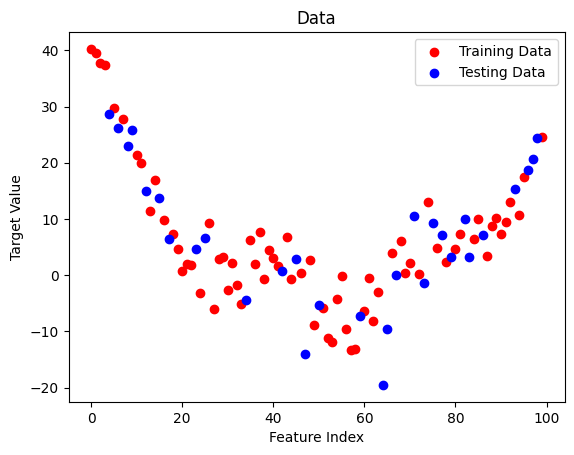

In [5]:
# Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

# Plot the data
plt.scatter(X_train, y_train, color='red', label='Training Data')
plt.scatter(X_test, y_test, color='blue', label='Testing Data')
plt.title('Data')
plt.xlabel('Feature Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()


## 2.2) Performance Metrics

In [6]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

## 2.3) Linear Regression Model

In [9]:
def linear_regression(X, y, lr=0.0001, epochs=20):
    m, n = X.shape
    theta = np.zeros(n + 1)  # Initialize weights and bias
    X = np.c_[np.ones(m), X]  # Add bias term

    for _ in range(epochs):
        predictions = np.dot(X, theta)
        errors = predictions - y
        gradient = (1 / m) * np.dot(X.T, errors)
        theta -= lr * gradient

    return theta

def predict(X, theta):
    X = np.c_[np.ones(X.shape[0]), X]
    return np.dot(X, theta)

# Train the model
theta = linear_regression(X_train, y_train)
y_pred_train = predict(X_train, theta)
y_pred_test = predict(X_test, theta)

# Evaluate the model
mse_train, mae_train, r2_train = evaluate_model(y_train, y_pred_train)
mse_test, mae_test, r2_test = evaluate_model(y_test, y_pred_test)
print(f"Train MAE: {mae_train}, Test MAE: {mae_test}")
print(f"Train MSE: {mse_train}, Test MSE: {mse_test}")
print(f"Train R2: {r2_train}, Test R2: {r2_test}")


Train MAE: 8.499897462141424, Test MAE: 10.477053778813836
Train MSE: 167.76810479942574, Test MSE: 176.21869711979335
Train R2: -0.1692910090684412, Test R2: -0.2050393365096963


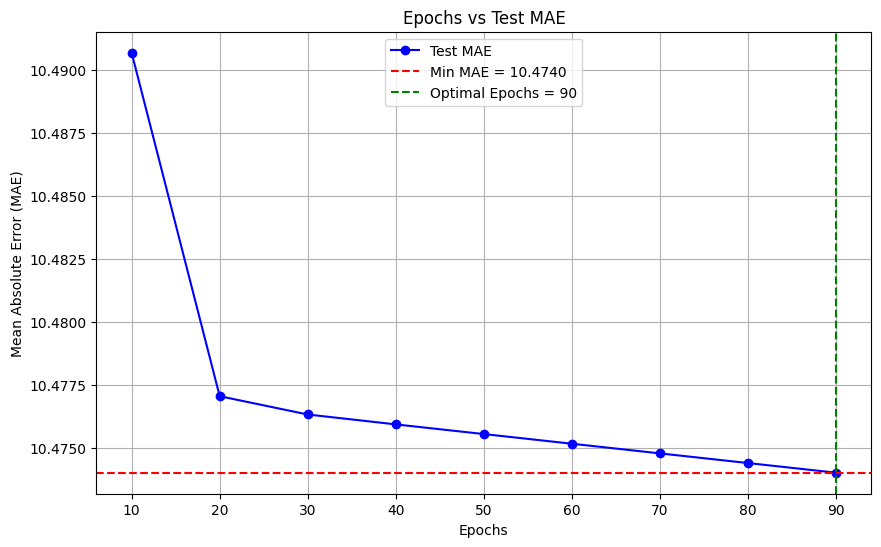

Minimum MAE: 10.4740 at 90 epochs


In [10]:
# evaluate for different epoch values
epoch_values = range(10, 100, 10)
mae_errors = []

for epochs in epoch_values:
    theta = linear_regression(X_train, y_train, epochs=epochs)
    y_pred_test = predict(X_test, theta)
    _, mae_test, _ = evaluate_model(y_test, y_pred_test)
    mae_errors.append(mae_test)

# Find the minimum MAE and corresponding epochs
min_mae = min(mae_errors)
optimal_epochs = epoch_values[mae_errors.index(min_mae)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epoch_values, mae_errors, marker='o', linestyle='-', color='b', label='Test MAE')
plt.axhline(y=min_mae, color='r', linestyle='--', label=f'Min MAE = {min_mae:.4f}')
plt.axvline(x=optimal_epochs, color='g', linestyle='--', label=f'Optimal Epochs = {optimal_epochs}')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Epochs vs Test MAE')
plt.legend()
plt.grid(True)
plt.show()

# Print the result
print(f"Minimum MAE: {min_mae:.4f} at {optimal_epochs} epochs")

## 2.4) Incremental Training

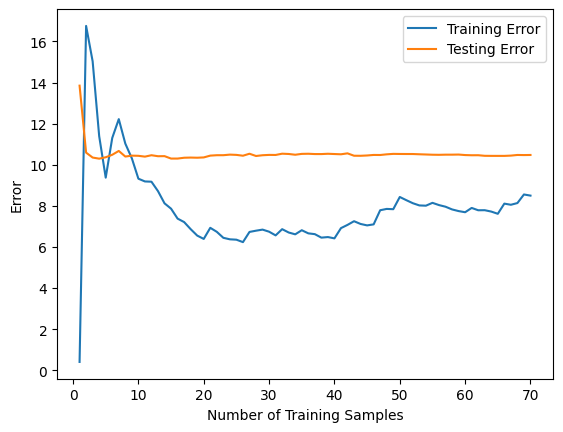

In [12]:
train_errors = []
test_errors = []

for i in range(1, len(X_train) + 1):
    theta = linear_regression(X_train[:i], y_train[:i])
    train_pred = predict(X_train[:i], theta)
    test_pred = predict(X_test, theta)

    train_errors.append(mean_absolute_error(y_train[:i], train_pred))
    test_errors.append(mean_absolute_error(y_test, test_pred))

# Plot errors
plt.plot(range(1, len(X_train) + 1), train_errors, label='Training Error')
plt.plot(range(1, len(X_train) + 1), test_errors, label='Testing Error')
plt.xlabel('Number of Training Samples')
plt.ylabel('Error')
plt.legend()
plt.show()

## 2.6) Polynomial Regression

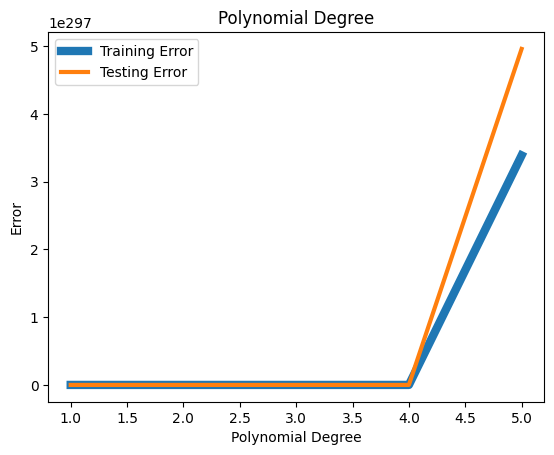

In [16]:
def polynomial_features(X, degree):
    return np.hstack([X ** i for i in range(1, degree + 1)])

degrees = [1, 2, 3, 4, 5]
train_errors, test_errors = [], []

for degree in degrees:
    X_train_poly = polynomial_features(X_train, degree)
    X_test_poly = polynomial_features(X_test, degree)

    theta = linear_regression(X_train_poly, y_train)
    train_pred = predict(X_train_poly, theta)
    test_pred = predict(X_test_poly, theta)

    train_errors.append(mean_absolute_error(y_train, train_pred))
    test_errors.append(mean_absolute_error(y_test, test_pred))

# Plot
plt.plot(degrees, train_errors, linewidth=6, label='Training Error')
plt.plot(degrees, test_errors, linewidth=3, label='Testing Error')
plt.title('Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Error')
plt.legend()
plt.show()


## 2.7) Scikit-Learn Algorithms

In [24]:
# Decision Tree
dt_model = DecisionTreeRegressor(random_state=3)
dt_param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_grid_search = GridSearchCV(estimator=dt_model, param_grid=dt_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
dt_grid_search.fit(X_train, y_train)

# Best Model
dt_best_model = dt_grid_search.best_estimator_
dt_y_pred = dt_best_model.predict(X_test)

# Evaluation
dt_mse = mean_squared_error(y_test, dt_y_pred)
dt_mae = mean_absolute_error(y_test, dt_y_pred)
dt_r2 = r2_score(y_test, dt_y_pred)

print(f"Decision Tree - Best Parameters: {dt_grid_search.best_params_}")
print(f"Decision Tree - MSE: {dt_mse}, MAE: {dt_mae}, R²: {dt_r2}")

Decision Tree - Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree - MSE: 39.52642096897488, MAE: 4.638473520022335, R²: 0.7297057980931672


In [25]:
# Random Forest
rf_model = RandomForestRegressor(random_state=3)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train, y_train)

# Best Model
rf_best_model = rf_grid_search.best_estimator_
rf_y_pred = rf_best_model.predict(X_test)

# Evaluation
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_mae = mean_absolute_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

print(f"Random Forest - Best Parameters: {rf_grid_search.best_params_}")
print(f"Random Forest - MSE: {rf_mse}, MAE: {rf_mae}, R²: {rf_r2}")

Random Forest - Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest - MSE: 30.231949078083172, MAE: 4.003126474385516, R²: 0.7932643445111689


In [26]:
# SVR
svr_model = SVR()
svr_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svr_grid_search = GridSearchCV(estimator=svr_model, param_grid=svr_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
svr_grid_search.fit(X_train, y_train)

# Best Model
svr_best_model = svr_grid_search.best_estimator_
svr_y_pred = svr_best_model.predict(X_test)

# Evaluation
svr_mse = mean_squared_error(y_test, svr_y_pred)
svr_mae = mean_absolute_error(y_test, svr_y_pred)
svr_r2 = r2_score(y_test, svr_y_pred)

print(f"SVR - Best Parameters: {svr_grid_search.best_params_}")
print(f"SVR - MSE: {svr_mse}, MAE: {svr_mae}, R²: {svr_r2}")

SVR - Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVR - MSE: 36.519379626243605, MAE: 4.610202636819901, R²: 0.7502689004411479


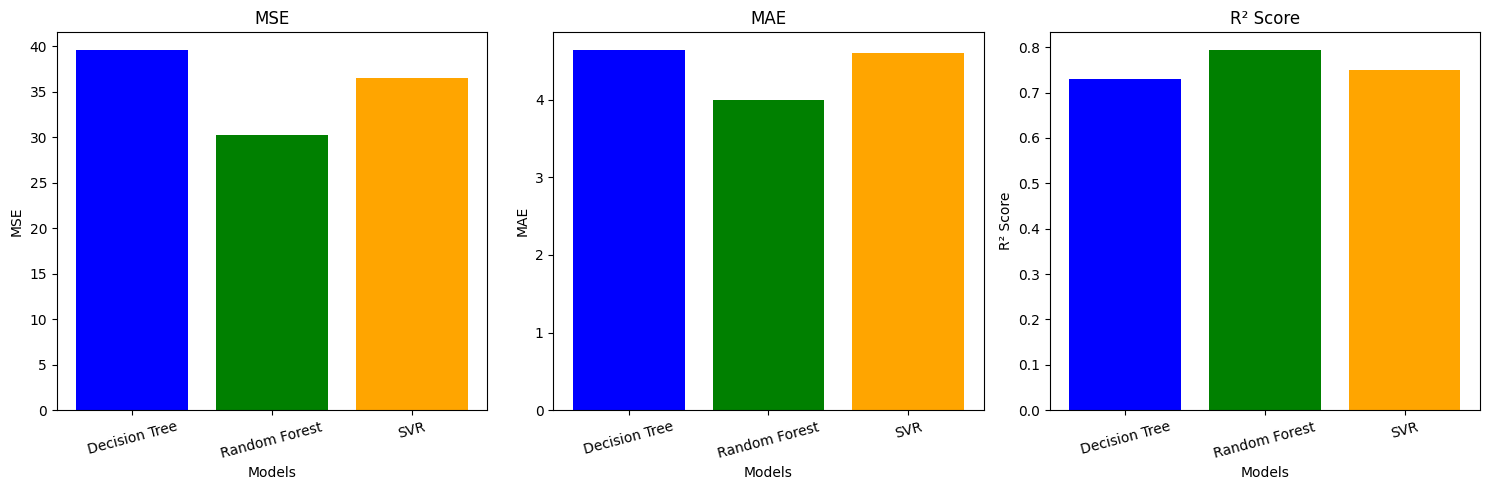

In [27]:
# Comparison
results = [
    {'Model': 'Decision Tree', 'MSE': dt_mse, 'MAE': dt_mae, 'R² Score': dt_r2},
    {'Model': 'Random Forest', 'MSE': rf_mse, 'MAE': rf_mae, 'R² Score': rf_r2},
    {'Model': 'SVR', 'MSE': svr_mse, 'MAE': svr_mae, 'R² Score': svr_r2}
]

results_df = pd.DataFrame(results)

metrics = ['MSE', 'MAE', 'R² Score']
fig, axs = plt.subplots(1, len(metrics), figsize=(15, 5))

for idx, metric in enumerate(metrics):
    axs[idx].bar(results_df['Model'], results_df[metric], color=['blue', 'green', 'orange'])
    axs[idx].set_title(metric)
    axs[idx].set_ylabel(metric)
    axs[idx].set_xlabel('Models')
    axs[idx].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()


## Regularization

In [29]:
# Linear Regression with L2 Regularization
def linear_regression_regularized(X, y, lr=0.0001, epochs=20, lambda_reg=0.1):
    m, n = X.shape
    theta = np.zeros(n + 1)
    X = np.c_[np.ones(m), X]

    for _ in range(epochs):
        predictions = np.dot(X, theta)
        errors = predictions - y
        gradient = (1 / m) * np.dot(X.T, errors)
        gradient[1:] += (lambda_reg / m) * theta[1:]  # Add regularization to weights (except bias)
        theta -= lr * gradient

    return theta

# Prediction function
def predict(X, theta):
    X = np.c_[np.ones(X.shape[0]), X]
    return np.dot(X, theta)

# Train the model with regularization
lambda_reg = 0.1  # Regularization strength
theta = linear_regression_regularized(X_train, y_train, lr=0.0001, epochs=1000, lambda_reg=lambda_reg)

# Make predictions
y_pred_train = predict(X_train, theta)
y_pred_test = predict(X_test, theta)

# Evaluate the model
mse_train, mae_train, r2_train = evaluate_model(y_train, y_pred_train)
mse_test, mae_test, r2_test = evaluate_model(y_test, y_pred_test)

# Print results
print(f"Train MAE: {mae_train}, Test MAE: {mae_test}")
print(f"Train MSE: {mse_train}, Test MSE: {mse_test}")
print(f"Train R2: {r2_train}, Test R2: {r2_test}")


Train MAE: 8.47652398141815, Test MAE: 10.4395425246007
Train MSE: 165.90339061304482, Test MSE: 174.61346811230086
Train R2: -0.15629453673405802, Test R2: -0.19406227147771582
